# BERT2BERT Abstractive Text Summarization

In [ ]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    BertTokenizerFast,
    EncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq
)
import evaluate

# Model
model_name = "bert-base-uncased"
max_input_length = 512
max_target_length = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the cnn_dailymail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
sample_size = min(5000, len(dataset['train']))
articles = dataset['train']['article'][:sample_size]
summaries = dataset['train']['highlights'][:sample_size]

article_lengths = [len(a.split()) for a in articles]
summary_lengths = [len(s.split()) for s in summaries]

print(f"Train: {len(dataset['train'])}, Val: {len(dataset['validation'])}, Test: {len(dataset['test'])}")


Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Train: 287113, Val: 13368, Test: 11490


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

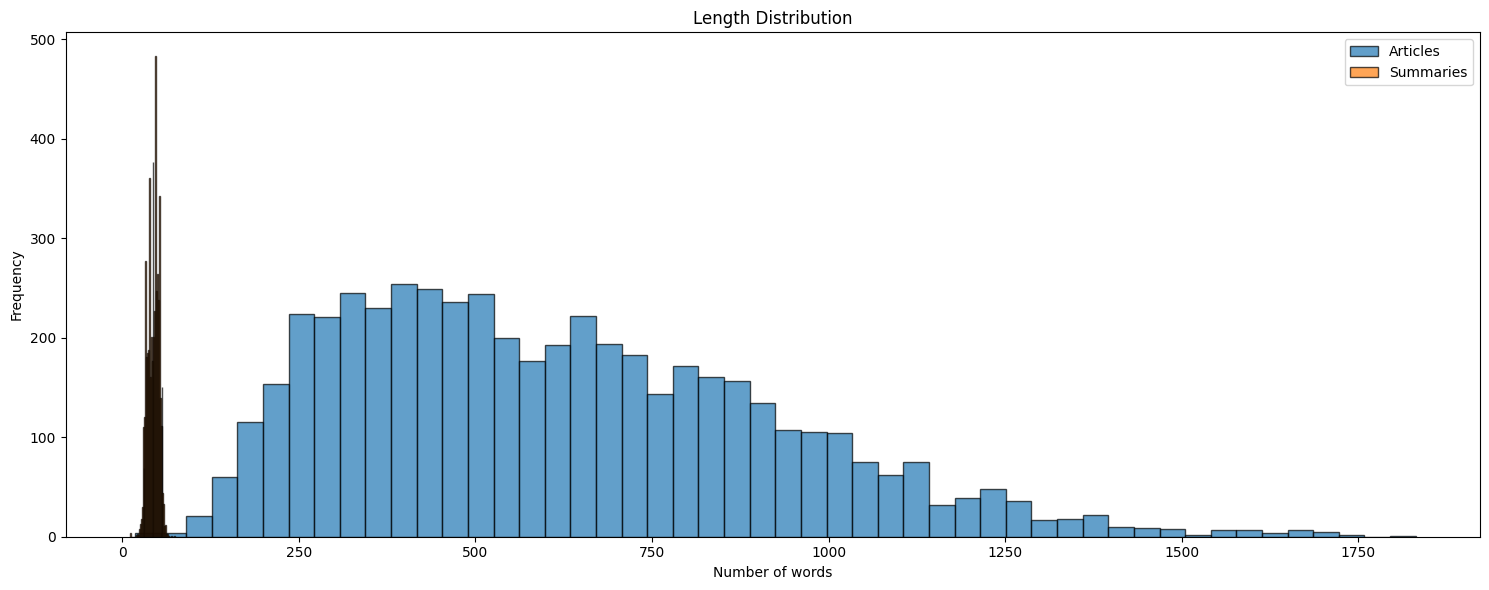

In [ ]:
# Ploting length distributions
plt.figure(figsize=(15, 6))
plt.hist(article_lengths, bins=50, alpha=0.7, label="Articles", edgecolor="black")
plt.hist(summary_lengths, bins=50, alpha=0.7, label="Summaries", edgecolor="black")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Length Distribution")
plt.legend()
plt.tight_layout()
plt.savefig("data_exploration.png", dpi=300)
plt.show()


# DATA PREPARATION  


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.max_length = max_target_length
model.config.min_length = 10
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.to(device)


Loading tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# Tokenizing

In [ ]:
def tokenize_function(examples):
    inputs = tokenizer(
        examples['article'],
        max_length=max_input_length,
        truncation=True,
        padding='max_length'
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['highlights'],
            max_length=max_target_length,
            truncation=True,
            padding='max_length'
        )
    inputs['labels'] = [
        [-100 if t == tokenizer.pad_token_id else t for t in l]
        for l in labels['input_ids']
    ]
    return inputs

# Tokenize dataset
print("Tokenizing dataset...")
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset['train'].column_names, num_proc=1)

train_dataset = tokenized_dataset['train'].select(range(min(10000, len(tokenized_dataset['train']))))
val_dataset = tokenized_dataset['validation'].select(range(min(1000, len(tokenized_dataset['validation']))))


Tokenizing dataset...


Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

# MODELING  

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/sample_data/bert2bert_output",
    eval_strategy="steps",
    save_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    weight_decay=0.01,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rouge1",
    greater_is_better=True,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=False,
    report_to=None,
    warmup_steps=500,
    lr_scheduler_type="linear",
    remove_unused_columns=False
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")


# Training

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])
    return {
        "rouge1": round(rouge["rouge1"] * 100, 4),
        "rouge2": round(rouge["rouge2"] * 100, 4),
        "rougeL": round(rouge["rougeL"] * 100, 4),
        "bleu": round(bleu["bleu"] * 100, 4)
    }

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train
print("Starting training...")
trainer.train()


/tmp/ipython-input-11-3325131527.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prudhvivardhan-p1997 (prudhvivardhan-p1997-university-of-hertfordshire) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu
1000,9.498300,4.633690,12.577300,1.023200,9.365900,1.555000
2000,8.884300,4.414640,14.267000,1.608200,10.312500,1.625700
3000,7.736000,4.348748,16.028700,1.946800,11.538400,1.825900
4000,7.548700,4.302086,16.699900,1.992100,11.694300,1.670400
5000,7.480000,4.252681,17.798200,2.300600,12.589600,1.754800
6000,6.741900,4.285970,17.793500,2.505900,12.406100,1.903300
7000,6.679600,4.266545,17.905700,2.526300,12.468200,1.994200


Streaming output truncated to the last 5000 lines.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model t

TrainOutput(global_step=7500, training_loss=8.070464404296875, metrics={'train_runtime': 7374.2786, 'train_samples_per_second': 4.068, 'train_steps_per_second': 1.017, 'total_flos': 1.84036230144e+16, 'train_loss': 8.070464404296875, 'epoch': 3.0})

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=db02284d5939a345c5a8a46198c1017d2a17623e3be63513060b1584fe553010
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# Predictions

In [ ]:

logs = [log for log in trainer.state.log_history if "eval_rouge1" in log]
with open("evaluation_results.json", "w") as f:
    json.dump(logs, f, indent=2)


os.makedirs("/content/sample_data/bert2bert_final_model", exist_ok=True)
model.save_pretrained("/content/sample_data/bert2bert_final_model")
tokenizer.save_pretrained("/content/sample_data/bert2bert_final_model")

# Generating sample predictions
print("Generating sample predictions...")
samples = dataset['validation'].select(range(5))
results = []
for sample in samples:
    inputs = tokenizer(
        sample['article'],
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_input_length
    ).to(device)
    ids = model.generate(
        **inputs,
        max_length=max_target_length,
        min_length=10,
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3,
        early_stopping=True
    )
    summary = tokenizer.decode(ids[0], skip_special_tokens=True)
    results.append({
        "article": sample["article"][:300] + "...",
        "generated": summary,
        "reference": sample["highlights"]
    })

with open("sample_predictions.json", "w") as f:
    json.dump(results, f, indent=2)


Saving evaluation results...
Saving model...
Generating sample predictions...


In [ ]:
import json

# Load and print sample predictions
with open("sample_predictions.json", "r") as f:
    samples = json.load(f)

for i, sample in enumerate(samples):
    print(f"\n=== Sample {i + 1} ===")
    print(f"Article (truncated): {sample['article']}")
    print(f"Generated Summary: {sample['generated']}")
    print(f"Reference Summary: {sample['reference']}")



=== Sample 1 ===
Article (truncated): (CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thoug...
Generated Summary: new : donor ' s kidney will be donor - to - live donor donor. donor donor : one donor is donor - in - cheek - looking donor. one donor can ' t be trusted, but one donor will have to donate. donor donors can donate $ 2 million per donor.
Reference Summary: Zully Broussard decided to give a kidney to a stranger .
A new computer program helped her donation spur transplants for six kidney patients .

=== Sample 2 ===
Article (truncated): (CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major 

# Results

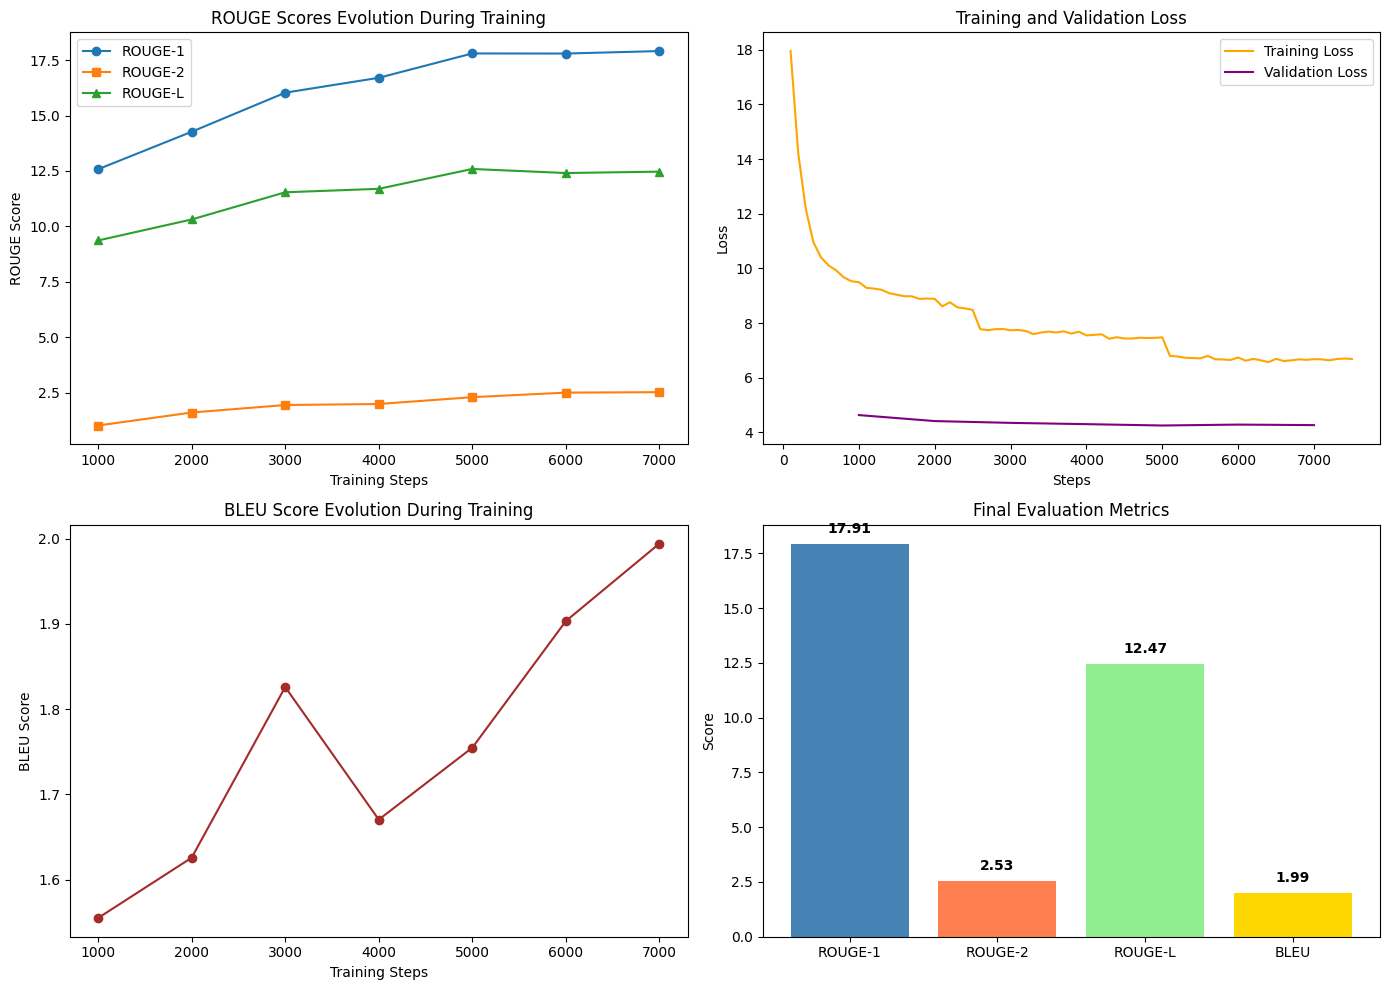

Plots saved to training_summary_plots.png


In [ ]:
import matplotlib.pyplot as plt

# Load evaluation results
with open("evaluation_results.json", "r") as f:
    eval_logs = json.load(f)

# Extracting metrics
steps = [log["step"] for log in eval_logs]
rouge1_scores = [log["eval_rouge1"] for log in eval_logs]
rouge2_scores = [log["eval_rouge2"] for log in eval_logs]
rougeL_scores = [log["eval_rougeL"] for log in eval_logs]
bleu_scores = [log["eval_bleu"] for log in eval_logs]
val_loss = [log["eval_loss"] for log in eval_logs]

# extracting training loss if logged
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log and "step" in log]
train_steps = [log["step"] for log in trainer.state.log_history if "loss" in log and "step" in log]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# ROUGE Scores
axs[0, 0].plot(steps, rouge1_scores, marker='o', label='ROUGE-1')
axs[0, 0].plot(steps, rouge2_scores, marker='s', label='ROUGE-2')
axs[0, 0].plot(steps, rougeL_scores, marker='^', label='ROUGE-L')
axs[0, 0].set_title("ROUGE Scores Evolution During Training")
axs[0, 0].set_xlabel("Training Steps")
axs[0, 0].set_ylabel("ROUGE Score")
axs[0, 0].legend()

# BLEU Score
axs[1, 0].plot(steps, bleu_scores, marker='o', color='brown')
axs[1, 0].set_title("BLEU Score Evolution During Training")
axs[1, 0].set_xlabel("Training Steps")
axs[1, 0].set_ylabel("BLEU Score")

# Training/Validation Loss
if train_loss:
    axs[0, 1].plot(train_steps, train_loss, label="Training Loss", color="orange")
axs[0, 1].plot(steps, val_loss, label="Validation Loss", color="purple")
axs[0, 1].set_title("Training and Validation Loss")
axs[0, 1].set_xlabel("Steps")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()

# Final Evaluation Metrics
final_rouge1 = rouge1_scores[-1]
final_rouge2 = rouge2_scores[-1]
final_rougeL = rougeL_scores[-1]
final_bleu = bleu_scores[-1]
axs[1, 1].bar(["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"],
              [final_rouge1, final_rouge2, final_rougeL, final_bleu],
              color=["steelblue", "coral", "lightgreen", "gold"])
for i, v in enumerate([final_rouge1, final_rouge2, final_rougeL, final_bleu]):
    axs[1, 1].text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')
axs[1, 1].set_title("Final Evaluation Metrics")
axs[1, 1].set_ylabel("Score")

plt.tight_layout()
plt.savefig("training_summary_plots.png", dpi=300)
plt.show()

print(" training_summary_plots.png")
